<a href="https://colab.research.google.com/github/yeon524/IDS/blob/main/IDS_obj1%2B3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Raw dataframe shape: (104, 7)


,Subject,Session,Scenario,Duration,Periods,Start,End
0,U0101,S0100,S1,35m36s,20,2021-10-14 11:25:34+09:00,2021-10-14 12:01:10+09:00
1,U0101,S0200,S1,28m54s,20,2021-10-14 13:17:42+09:00,2021-10-14 13:46:36+09:00
2,U0101,S0300,S1,28m58s,20,2021-10-14 14:09:10+09:00,2021-10-14 14:38:08+09:00
3,U0101,S0400,S1,30m55s,20,2021-10-14 14:59:48+09:00,2021-10-14 15:30:43+09:00
4,U0101,S0500,S1,27m35s,20,2021-10-14 15:54:05+09:00,2021-10-14 16:21:40+09:00


Cleaned dataframe shape: (104, 8)
Scenarios: ['S1' 'S2' 'S3' 'S4']

Average duration (sec) by scenario


,Scenario,duration_sec
0,S1,2019.666667
1,S2,1846.350000
2,S3,1698.050000
3,S4,1388.600000



Average periods by scenario


,Scenario,Periods
0,S1,19.037037
1,S2,20.000000
2,S3,19.600000
3,S4,19.500000



Efficiency (sec per period) by scenario


,Scenario,sec_per_period
0,S1,106.336633
1,S2,92.317500
2,S3,87.145833
3,S4,71.220000


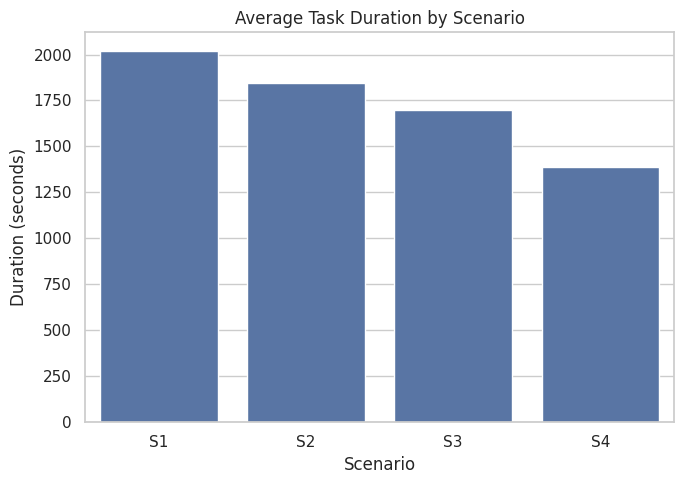

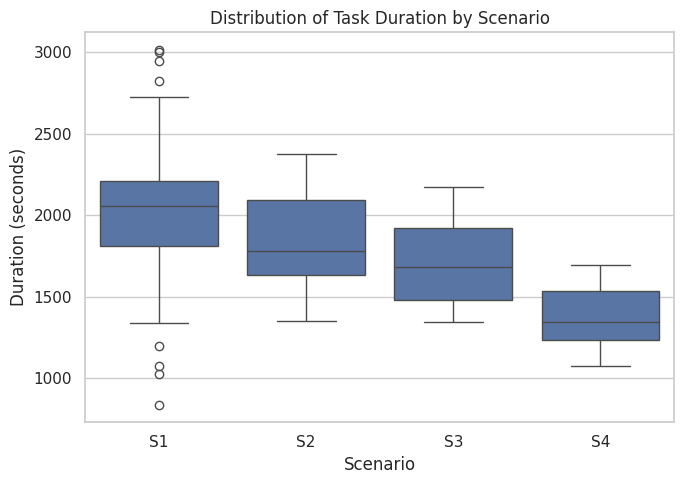

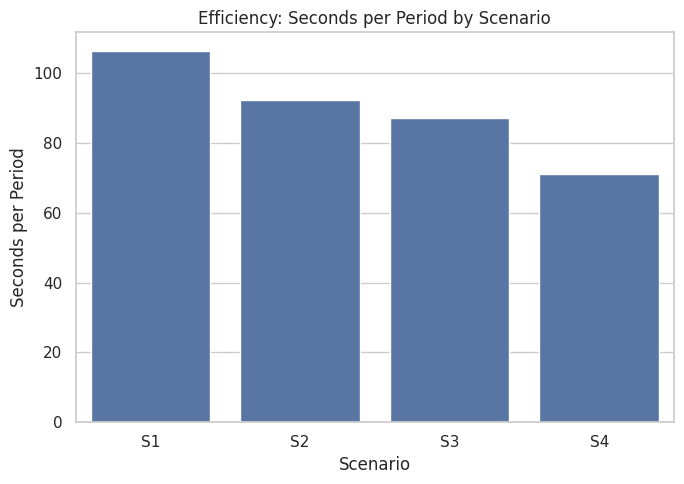

In [14]:

!rm -rf openpack-dataset
!git clone https://github.com/yeon524/openpack-dataset.git -q

import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

os.chdir("/content/openpack-dataset/docs/data-collection")



rows = []
with open("sessions.md", "r", encoding="utf-8") as f:
    for line in f:

        if "|" not in line:
            continue
        if "Subject" in line or "---" in line:
            continue

        parts = [c.strip() for c in line.split("|") if c.strip()]
        if not parts:
            continue


        if not parts[0].startswith("U0"):
            continue


        if len(parts) >= 7:
            rows.append(parts[:7])

df = pd.DataFrame(rows, columns=["Subject","Session","Scenario",
                                 "Duration","Periods","Start","End"])

print("Raw dataframe shape:", df.shape)
display(df.head())



def duration_to_sec(x):
    if pd.isna(x):
        return np.nan
    x = x.strip()
    m = re.match(r"(\d+)m(\d+)s", x)
    if m:
        minutes = int(m.group(1))
        seconds = int(m.group(2))
        return minutes * 60 + seconds
    return np.nan  # 예상 패턴 아니면 NaN

df["duration_sec"] = df["Duration"].apply(duration_to_sec)



df["Scenario"] = df["Scenario"].str.strip()
valid_scenarios = ["S1","S2","S3","S4"]
df_clean = df[df["Scenario"].isin(valid_scenarios)].copy()

print("Cleaned dataframe shape:", df_clean.shape)
print("Scenarios:", df_clean["Scenario"].unique())



df_clean["Periods"] = pd.to_numeric(df_clean["Periods"], errors="coerce")
df_clean = df_clean.dropna(subset=["Periods"])



# (1) 평균 작업 시간
scenario_stats = (
    df_clean.groupby("Scenario")["duration_sec"]
            .mean()
            .reset_index()
)

# S1~S4 순서 정렬
order = ["S1","S2","S3","S4"]
scenario_stats["Scenario"] = pd.Categorical(scenario_stats["Scenario"],
                                            categories=order,
                                            ordered=True)
scenario_stats = scenario_stats.sort_values("Scenario")

print("\nAverage duration (sec) by scenario")
display(scenario_stats)

# (2) 시나리오별 평균 Periods
period_stats = (
    df_clean.groupby("Scenario")["Periods"]
            .mean()
            .reset_index()
)

period_stats["Scenario"] = pd.Categorical(period_stats["Scenario"],
                                          categories=order,
                                          ordered=True)
period_stats = period_stats.sort_values("Scenario")

print("\nAverage periods by scenario")
display(period_stats)

# (3) 효율: Seconds per Period
df_clean["sec_per_period"] = df_clean["duration_sec"] / df_clean["Periods"]

eff_stats = (
    df_clean.groupby("Scenario")["sec_per_period"]
            .mean()
            .reset_index()
)

eff_stats["Scenario"] = pd.Categorical(eff_stats["Scenario"],
                                       categories=order,
                                       ordered=True)
eff_stats = eff_stats.sort_values("Scenario")

print("\nEfficiency (sec per period) by scenario")
display(eff_stats)



sns.set(style="whitegrid")

# (A) Scenario별 평균 작업 시간
plt.figure(figsize=(7,5))
sns.barplot(data=scenario_stats, x="Scenario", y="duration_sec")
plt.title("Average Task Duration by Scenario")
plt.xlabel("Scenario")
plt.ylabel("Duration (seconds)")
plt.tight_layout()
plt.show()

# (B) Scenario별 작업 시간 분포 (Boxplot)
plt.figure(figsize=(7,5))
sns.boxplot(data=df_clean, x="Scenario", y="duration_sec",
            order=order)
plt.title("Distribution of Task Duration by Scenario")
plt.xlabel("Scenario")
plt.ylabel("Duration (seconds)")
plt.tight_layout()
plt.show()


# (C) Scenario별 효율 (Seconds per Period)
plt.figure(figsize=(7,5))
sns.barplot(data=eff_stats, x="Scenario", y="sec_per_period")
plt.title("Efficiency: Seconds per Period by Scenario")
plt.xlabel("Scenario")
plt.ylabel("Seconds per Period")
plt.tight_layout()
plt.show()


=== Worker-level speed & consistency (전체 세션 기준) ===


,Subject,mean,std,count,cv
3,U0104,2294.25,870.376308,4,0.379373
1,U0102,2277.00,457.419938,5,0.200887
8,U0109,2216.60,298.738682,5,0.134773
7,U0108,2191.80,131.968557,5,0.060210
10,U0111,2180.60,286.267882,5,0.131279
4,U0105,2140.60,192.986528,5,0.090155
5,U0106,2063.40,682.802900,5,0.330912
13,U0203,1940.60,232.493656,5,0.119805
15,U0205,1865.40,258.640291,5,0.138651
11,U0201,1823.60,434.876189,5,0.238471


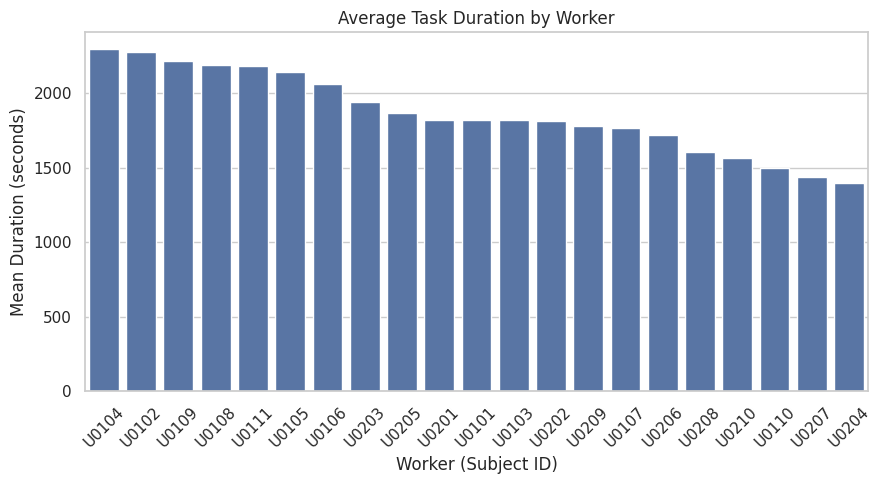

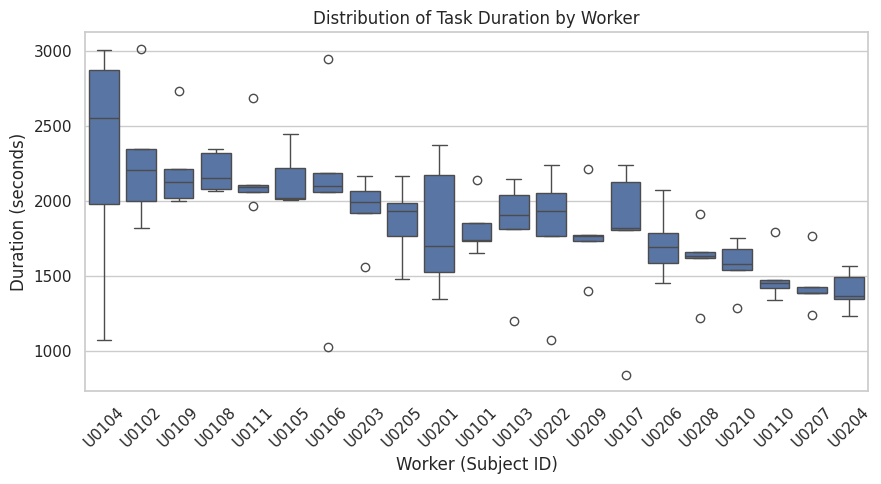

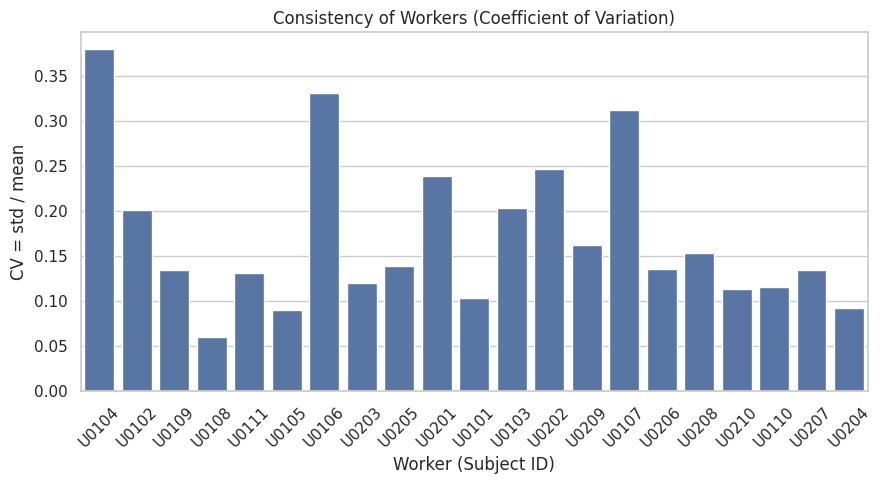

=== Average duration by Worker x Scenario ===


Scenario,S1,S2,S3,S4
Subject,,,,
U0101,1823.60,NaN,NaN,NaN
U0102,2277.00,NaN,NaN,NaN
U0103,1820.20,NaN,NaN,NaN
U0104,2294.25,NaN,NaN,NaN
U0105,2140.60,NaN,NaN,NaN
U0106,2063.40,NaN,NaN,NaN
U0107,1765.40,NaN,NaN,NaN
U0108,2191.80,NaN,NaN,NaN
U0109,2216.60,NaN,NaN,NaN


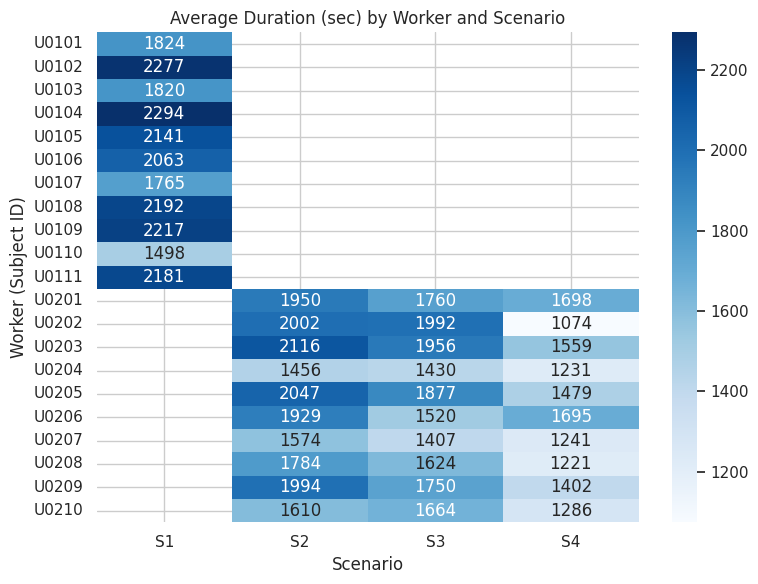

In [15]:
# ============================================
#  Worker(Subject)별 속도 & 일관성 분석
#  (df_clean 이 이미 존재한다고 가정)
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# 1) Worker(Subject)별 기본 통계 ==============================
worker_stats = (
    df_clean.groupby("Subject")["duration_sec"]
            .agg(["mean", "std", "count"])
            .reset_index()
)

# 일관성 지표: 표준편차 / 평균  (Coefficient of Variation)
worker_stats["cv"] = worker_stats["std"] / worker_stats["mean"]

# 평균 시간 기준으로 정렬 (느린 사람 순)
worker_stats = worker_stats.sort_values("mean", ascending=False)

print("=== Worker-level speed & consistency (전체 세션 기준) ===")
display(worker_stats)

# 2) 시각화 1: Worker별 평균 작업 시간 =========================
plt.figure(figsize=(9,5))
sns.barplot(data=worker_stats, x="Subject", y="mean")
plt.title("Average Task Duration by Worker")
plt.xlabel("Worker (Subject ID)")
plt.ylabel("Mean Duration (seconds)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3) 시각화 2: Worker별 작업 시간 분포(Boxplot) =================
plt.figure(figsize=(9,5))
sns.boxplot(data=df_clean, x="Subject", y="duration_sec",
            order=worker_stats["Subject"])  # 위에서 정렬한 순서대로
plt.title("Distribution of Task Duration by Worker")
plt.xlabel("Worker (Subject ID)")
plt.ylabel("Duration (seconds)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4) 시각화 3: Worker별 일관성(CV) ============================
plt.figure(figsize=(9,5))
sns.barplot(data=worker_stats, x="Subject", y="cv")
plt.title("Consistency of Workers (Coefficient of Variation)")
plt.xlabel("Worker (Subject ID)")
plt.ylabel("CV = std / mean")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 5) 추가: Scenario x Worker 교차 테이블 (평균 시간) ==============
scenario_worker_stats = (
    df_clean.groupby(["Subject", "Scenario"])["duration_sec"]
            .mean()
            .reset_index()
            .pivot(index="Subject", columns="Scenario", values="duration_sec")
)

print("=== Average duration by Worker x Scenario ===")
display(scenario_worker_stats)

plt.figure(figsize=(8,6))
sns.heatmap(scenario_worker_stats, annot=True, fmt=".0f",
            cmap="Blues")
plt.title("Average Duration (sec) by Worker and Scenario")
plt.xlabel("Scenario")
plt.ylabel("Worker (Subject ID)")
plt.tight_layout()
plt.show()


Raw dataframe shape: (104, 7)


,Subject,Session,Scenario,Duration,Periods,Start,End
0,U0101,S0100,S1,35m36s,20,2021-10-14 11:25:34+09:00,2021-10-14 12:01:10+09:00
1,U0101,S0200,S1,28m54s,20,2021-10-14 13:17:42+09:00,2021-10-14 13:46:36+09:00
2,U0101,S0300,S1,28m58s,20,2021-10-14 14:09:10+09:00,2021-10-14 14:38:08+09:00
3,U0101,S0400,S1,30m55s,20,2021-10-14 14:59:48+09:00,2021-10-14 15:30:43+09:00
4,U0101,S0500,S1,27m35s,20,2021-10-14 15:54:05+09:00,2021-10-14 16:21:40+09:00


Cleaned dataframe shape: (104, 8)
Scenarios: ['S1' 'S2' 'S3' 'S4']

Raw subjects:


,Subject,Sex,Age,DominantHand,Experience,Note
0,U0101,F,-,Right,-,None
1,U0102,F,-,Right,-,None
2,U0103,F,50s,Right,6 Month,None
3,U0104,F,50s,Right,1 Month,None
4,U0105,F,30s,Right,4 Year,None



Processed subjects (age_num, sex_code, exp_months):


,Subject,Sex,Age,DominantHand,Experience,Note,age_num,sex_code,exp_months
0,U0101,F,-,Right,-,None,NaN,0,0.0
1,U0102,F,-,Right,-,None,NaN,0,0.0
2,U0103,F,50s,Right,6 Month,None,50.0,0,6.0
3,U0104,F,50s,Right,1 Month,None,50.0,0,1.0
4,U0105,F,30s,Right,4 Year,None,30.0,0,48.0



Merged data example:


,Subject,Session,Scenario,Duration,Periods,Start,End,duration_sec,sec_per_period,age_num,sex_code,exp_months
0,U0101,S0100,S1,35m36s,20,2021-10-14 11:25:34+09:00,2021-10-14 12:01:10+09:00,2136,106.80,NaN,0,0.0
1,U0101,S0200,S1,28m54s,20,2021-10-14 13:17:42+09:00,2021-10-14 13:46:36+09:00,1734,86.70,NaN,0,0.0
2,U0101,S0300,S1,28m58s,20,2021-10-14 14:09:10+09:00,2021-10-14 14:38:08+09:00,1738,86.90,NaN,0,0.0
3,U0101,S0400,S1,30m55s,20,2021-10-14 14:59:48+09:00,2021-10-14 15:30:43+09:00,1855,92.75,NaN,0,0.0
4,U0101,S0500,S1,27m35s,20,2021-10-14 15:54:05+09:00,2021-10-14 16:21:40+09:00,1655,82.75,NaN,0,0.0



Average duration (sec) by scenario


,Scenario,duration_sec
0,S1,2019.666667
1,S2,1846.350000
2,S3,1698.050000
3,S4,1388.600000



Average periods by scenario


,Scenario,Periods
0,S1,19.037037
1,S2,20.000000
2,S3,19.600000
3,S4,19.500000



Efficiency (sec per period) by scenario


,Scenario,sec_per_period
0,S1,106.336633
1,S2,92.317500
2,S3,87.145833
3,S4,71.220000


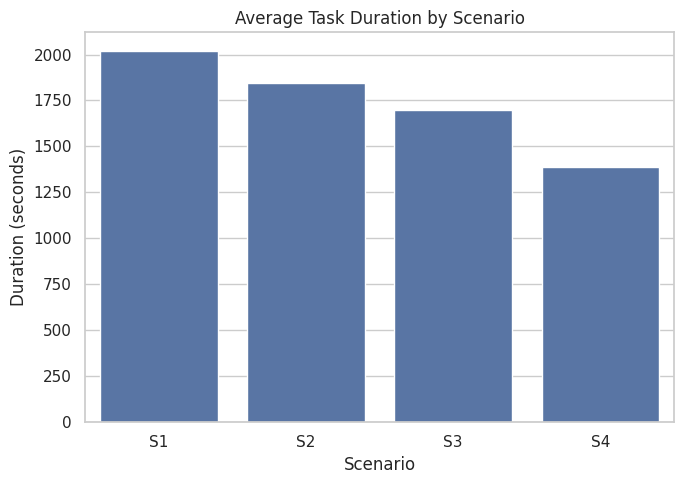

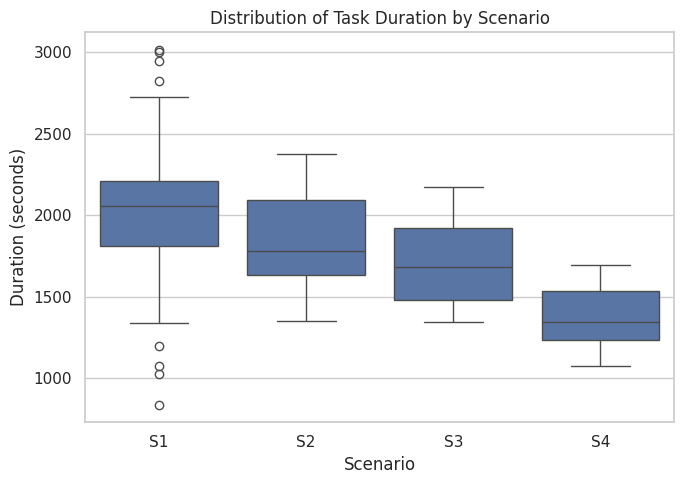

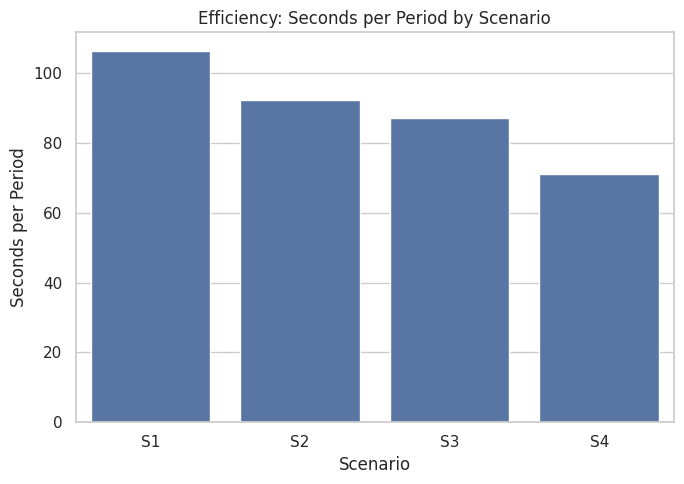


===== Scenario-wise Correlation (Human factors vs Efficiency) =====

[Scenario S1] correlation matrix:
                duration_sec  sec_per_period   age_num  sex_code  exp_months
duration_sec        1.000000        0.746945 -0.092712  0.138338    0.021121
sec_per_period      0.746945        1.000000  0.030405  0.169791   -0.092005
age_num            -0.092712        0.030405  1.000000 -0.431187   -0.465175
sex_code            0.138338        0.169791 -0.431187  1.000000   -0.181622
exp_months          0.021121       -0.092005 -0.465175 -0.181622    1.000000


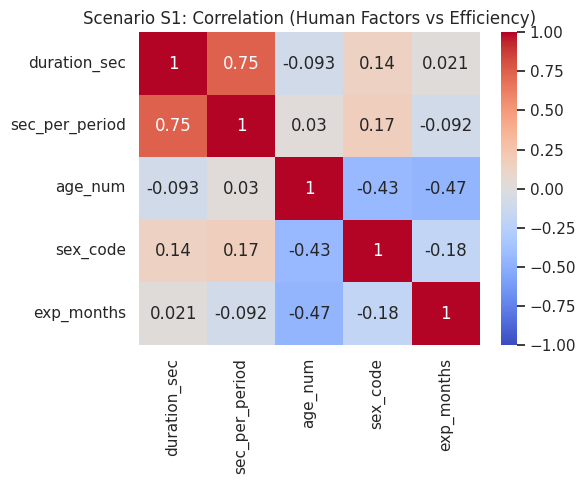


[Scenario S2] correlation matrix:
                duration_sec  sec_per_period   age_num  sex_code  exp_months
duration_sec        1.000000        1.000000 -0.395624  0.190137    0.743840
sec_per_period      1.000000        1.000000 -0.395624  0.190137    0.743840
age_num            -0.395624       -0.395624  1.000000 -0.860268   -0.862222
sex_code            0.190137        0.190137 -0.860268  1.000000         NaN
exp_months          0.743840        0.743840 -0.862222       NaN    1.000000


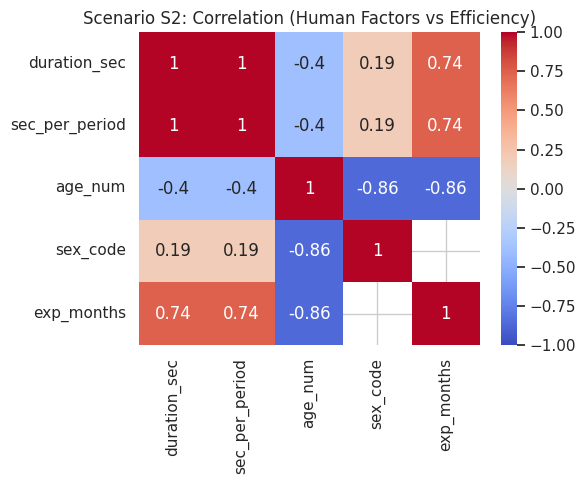


[Scenario S3] correlation matrix:
                duration_sec  sec_per_period   age_num  sex_code  exp_months
duration_sec        1.000000        0.694693 -0.122545 -0.114774    0.742497
sec_per_period      0.694693        1.000000 -0.300514  0.105467    0.742497
age_num            -0.122545       -0.300514  1.000000 -0.860268   -0.862222
sex_code           -0.114774        0.105467 -0.860268  1.000000         NaN
exp_months          0.742497        0.742497 -0.862222       NaN    1.000000


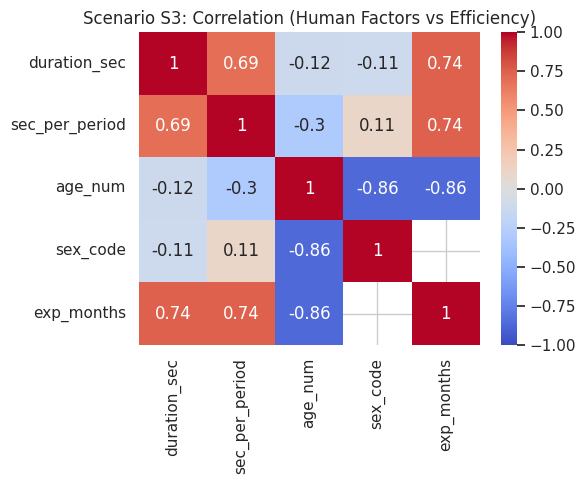


[Scenario S4] correlation matrix:
                duration_sec  sec_per_period   age_num  sex_code  exp_months
duration_sec        1.000000        0.848264 -0.416415  0.464652    0.070307
sec_per_period      0.848264        1.000000 -0.506224  0.374425    0.770187
age_num            -0.416415       -0.506224  1.000000 -0.860268   -0.862222
sex_code            0.464652        0.374425 -0.860268  1.000000         NaN
exp_months          0.070307        0.770187 -0.862222       NaN    1.000000


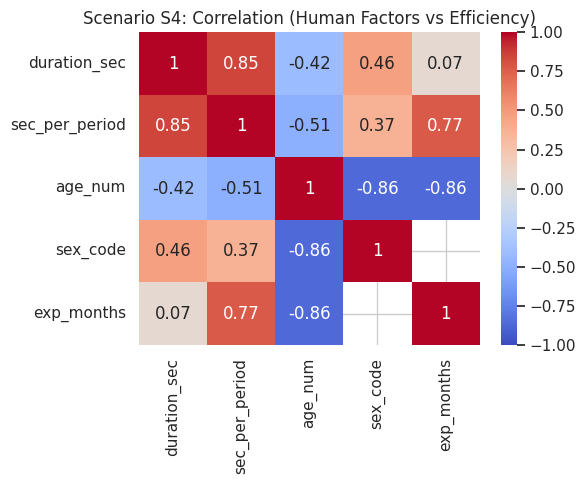

In [16]:
!rm -rf openpack-dataset
!git clone https://github.com/yeon524/openpack-dataset.git -q

import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------
# 0. 기본 세팅
# ------------------------------------------------
os.chdir("/content/openpack-dataset/docs/data-collection")
sns.set(style="whitegrid")

# ------------------------------------------------
# 1. sessions.md 읽어서 시나리오별 효율 계산
# ------------------------------------------------
rows = []
with open("sessions.md", "r", encoding="utf-8") as f:
    for line in f:
        # 표 줄만 사용
        if "|" not in line:
            continue
        if "Subject" in line or "---" in line:
            continue

        parts = [c.strip() for c in line.split("|") if c.strip()]
        if not parts:
            continue

        # 실제 데이터 행만 (U0101 등)
        if not parts[0].startswith("U0"):
            continue

        # columns: Subject | Session | Scenario | Duration | Periods | Start | End
        if len(parts) >= 7:
            rows.append(parts[:7])

df = pd.DataFrame(
    rows,
    columns=["Subject", "Session", "Scenario", "Duration", "Periods", "Start", "End"]
)

print("Raw dataframe shape:", df.shape)
display(df.head())

# Duration "35m36s" -> 초
def duration_to_sec(x):
    if pd.isna(x):
        return np.nan
    x = x.strip()
    m = re.match(r"(\d+)m(\d+)s", x)
    if m:
        minutes = int(m.group(1))
        seconds = int(m.group(2))
        return minutes * 60 + seconds
    return np.nan  # 예상 패턴 아니면 NaN

df["duration_sec"] = df["Duration"].apply(duration_to_sec)

# 시나리오 필터링
df["Scenario"] = df["Scenario"].str.strip()
valid_scenarios = ["S1", "S2", "S3", "S4"]
df_clean = df[df["Scenario"].isin(valid_scenarios)].copy()

print("Cleaned dataframe shape:", df_clean.shape)
print("Scenarios:", df_clean["Scenario"].unique())

# Periods 숫자 변환
df_clean["Periods"] = pd.to_numeric(df_clean["Periods"], errors="coerce")
df_clean = df_clean.dropna(subset=["Periods"])

# 효율: sec per period
df_clean["sec_per_period"] = df_clean["duration_sec"] / df_clean["Periods"]

# ------------------------------------------------
# 2. subjects.md 읽어서 사람 특성 정리
#    columns: Subject | Sex | Age | Dominant Hand | Experience | Note
# ------------------------------------------------
sub_rows = []
with open("subjects.md", "r", encoding="utf-8") as f:
    for line in f:
        if "|" not in line:
            continue
        if "Subject" in line or "---" in line:
            continue

        parts = [c.strip() for c in line.split("|") if c.strip()]
        if not parts:
            continue

        if not parts[0].startswith("U0"):
            continue

        # Subject, Sex, Age, Dominant Hand, Experience, Note (보통 6개)
        sub_rows.append(parts[:6])

sub_cols = ["Subject", "Sex", "Age", "DominantHand", "Experience", "Note"]
df_subj = pd.DataFrame(sub_rows, columns=sub_cols)

print("\nRaw subjects:")
display(df_subj.head())

# Age: "20s" -> 20 (나이대 중심값으로 사용)
def parse_age(s):
    if pd.isna(s):
        return np.nan
    s = s.strip()
    if s == "-" or s == "":
        return np.nan
    if s.endswith("s") and s[:-1].isdigit():
        return int(s[:-1])
    return np.nan

df_subj["age_num"] = df_subj["Age"].apply(parse_age)

# Sex: F/M -> 0/1
df_subj["sex_code"] = df_subj["Sex"].map({"F": 0, "M": 1})

# Experience: "-", "6 Month", "4 Year" -> 월(month) 단위 숫자로 변환
def parse_exp(s):
    if pd.isna(s):
        return np.nan
    s = s.strip()
    if s == "-" or s == "":
        return 0
    m = re.match(r"(\d+)\s*Month", s, flags=re.IGNORECASE)
    if m:
        return int(m.group(1))
    m = re.match(r"(\d+)\s*Year", s, flags=re.IGNORECASE)
    if m:
        return int(m.group(1)) * 12
    return np.nan

df_subj["exp_months"] = df_subj["Experience"].apply(parse_exp)

print("\nProcessed subjects (age_num, sex_code, exp_months):")
display(df_subj.head())

# ------------------------------------------------
# 3. sessions + subjects merge
# ------------------------------------------------
df_all = df_clean.merge(df_subj[["Subject", "age_num", "sex_code", "exp_months"]],
                        on="Subject", how="left")

print("\nMerged data example:")
display(df_all.head())

# ------------------------------------------------
# 4. 시나리오별 효율 통계 (기존 코드 유지)
# ------------------------------------------------
order = ["S1", "S2", "S3", "S4"]

# (1) 평균 작업 시간
scenario_stats = (
    df_clean.groupby("Scenario")["duration_sec"]
            .mean()
            .reset_index()
)
scenario_stats["Scenario"] = pd.Categorical(scenario_stats["Scenario"],
                                            categories=order, ordered=True)
scenario_stats = scenario_stats.sort_values("Scenario")

print("\nAverage duration (sec) by scenario")
display(scenario_stats)

# (2) 평균 Periods
period_stats = (
    df_clean.groupby("Scenario")["Periods"]
            .mean()
            .reset_index()
)
period_stats["Scenario"] = pd.Categorical(period_stats["Scenario"],
                                          categories=order, ordered=True)
period_stats = period_stats.sort_values("Scenario")

print("\nAverage periods by scenario")
display(period_stats)

# (3) 효율: Seconds per Period
eff_stats = (
    df_clean.groupby("Scenario")["sec_per_period"]
            .mean()
            .reset_index()
)
eff_stats["Scenario"] = pd.Categorical(eff_stats["Scenario"],
                                       categories=order, ordered=True)
eff_stats = eff_stats.sort_values("Scenario")

print("\nEfficiency (sec per period) by scenario")
display(eff_stats)

# ------------------------------------------------
# 5. 시각화 (기존 그래프)
# ------------------------------------------------
plt.figure(figsize=(7,5))
sns.barplot(data=scenario_stats, x="Scenario", y="duration_sec")
plt.title("Average Task Duration by Scenario")
plt.xlabel("Scenario")
plt.ylabel("Duration (seconds)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,5))
sns.boxplot(data=df_clean, x="Scenario", y="duration_sec", order=order)
plt.title("Distribution of Task Duration by Scenario")
plt.xlabel("Scenario")
plt.ylabel("Duration (seconds)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,5))
sns.barplot(data=eff_stats, x="Scenario", y="sec_per_period")
plt.title("Efficiency: Seconds per Period by Scenario")
plt.xlabel("Scenario")
plt.ylabel("Seconds per Period")
plt.tight_layout()
plt.show()

# ------------------------------------------------
# 6. 사람 특성과 효율성의 상관분석 (시나리오별)
#    metric: duration_sec, sec_per_period
#    features: age_num, sex_code, exp_months
# ------------------------------------------------
corr_cols = ["duration_sec", "sec_per_period", "age_num", "sex_code", "exp_months"]

print("\n===== Scenario-wise Correlation (Human factors vs Efficiency) =====")
for scen in order:
    sub = df_all[df_all["Scenario"] == scen].copy()
    if sub.empty:
        continue

    # 최소 2행 이상 있어야 상관계수 의미 있음
    if sub[corr_cols].dropna(how="all").shape[0] < 2:
        print(f"\n[Scenario {scen}] 데이터가 너무 적어서 상관분석 불가")
        continue

    corr = sub[corr_cols].corr()
    print(f"\n[Scenario {scen}] correlation matrix:")
    print(corr)

    plt.figure(figsize=(6,5))
    sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
    plt.title(f"Scenario {scen}: Correlation (Human Factors vs Efficiency)")
    plt.tight_layout()
    plt.show()


In [17]:
import numpy as np
import pandas as pd

# 효율성 지표 선택
target = "sec_per_period"
features = ["age_num", "sex_code", "exp_months"]

scenario_list = ["S1", "S2", "S3", "S4"]

rankings = {}

for scen in scenario_list:
    sub = df_all[df_all["Scenario"] == scen]

    # 상관계수 계산
    corr = sub[[target] + features].corr().loc[target, features]

    # 절댓값으로 영향력 정렬
    corr_abs_sorted = corr.abs().sort_values(ascending=False)

    rankings[scen] = corr_abs_sorted
    print(f"\n===== Scenario {scen} 영향력 랭킹 =====")
    display(corr_abs_sorted)

# 전체 평균 영향력 순위
avg_rank = pd.concat(rankings, axis=1).mean(axis=1).sort_values(ascending=False)

print("\n====== 전체 시나리오 평균 영향력 랭킹 (절댓값 기준) ======")
display(avg_rank)



===== Scenario S1 영향력 랭킹 =====


,sec_per_period
sex_code,0.169791
exp_months,0.092005
age_num,0.030405



===== Scenario S2 영향력 랭킹 =====


,sec_per_period
exp_months,0.743840
age_num,0.395624
sex_code,0.190137



===== Scenario S3 영향력 랭킹 =====


,sec_per_period
exp_months,0.742497
age_num,0.300514
sex_code,0.105467



===== Scenario S4 영향력 랭킹 =====


,sec_per_period
exp_months,0.770187
age_num,0.506224
sex_code,0.374425



====== 전체 시나리오 평균 영향력 랭킹 (절댓값 기준) ======


,0
exp_months,0.587132
age_num,0.308192
sex_code,0.209955



===== 전체 시나리오 평균 영향력 랭킹 (절댓값 기준) =====


,0
exp_months,0.587132
age_num,0.308192
sex_code,0.209955


/tmp/ipython-input-3671791689.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_mean_abs.values, y=corr_mean_abs.index, palette="viridis")


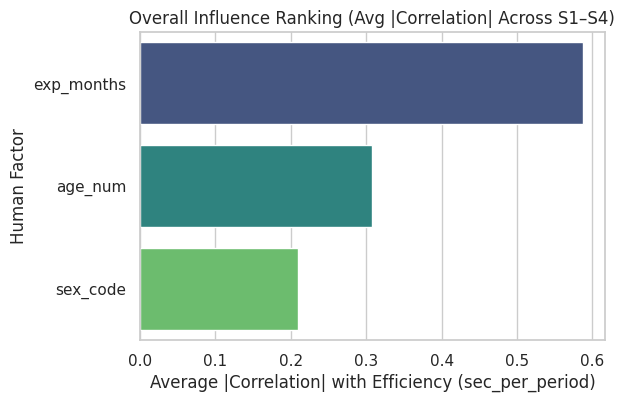

In [18]:
target = "sec_per_period"
features = ["age_num", "sex_code", "exp_months"]

scenario_list = ["S1", "S2", "S3", "S4"]
corr_all = {}

for scen in scenario_list:
    sub = df_all[df_all["Scenario"] == scen]
    corr = sub[[target] + features].corr().loc[target, features]
    corr_all[scen] = corr

# DataFrame으로 묶기
corr_df = pd.DataFrame(corr_all)

# 절댓값 기준 평균 영향력 계산
corr_mean_abs = corr_df.abs().mean(axis=1).sort_values(ascending=False)

print("\n===== 전체 시나리오 평균 영향력 랭킹 (절댓값 기준) =====")
display(corr_mean_abs)

# 보기 좋게 막대그래프도 출력
plt.figure(figsize=(6,4))
sns.barplot(x=corr_mean_abs.values, y=corr_mean_abs.index, palette="viridis")
plt.title("Overall Influence Ranking (Avg |Correlation| Across S1–S4)")
plt.xlabel("Average |Correlation| with Efficiency (sec_per_period)")
plt.ylabel("Human Factor")
plt.show()
